# Импорт пакетов

In [1]:
# !pip install joblib
# Импортируем функции для параллелизации
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import os
import glob
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

In [2]:
df_games = pd.read_csv("games_clean.csv")
df_games = df_games[['AppID', 'Name', 'Positive', 'Negative']]

# Смотрим на данные

In [3]:
game_review_files = glob.glob("SteamReviewsCombined/*.csv")
len(game_review_files)

71148

In [4]:
# Структура 
pd.read_csv(game_review_files[0])

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,149154021,english,"Early access done right. Game is stable, game ...",1698611406,1698611406,True,0,0.000000,0,True,False,True,76561198018559321,0,8,14632,6378,14458,1698626368
1,149150184,english,The best 4x game I've ever played.\n\nSome imp...,1698607627,1698607627,True,0,0.000000,0,True,False,True,76561198027353332,74,2,20777,5237,20622,1698626260
2,149081843,french,1ère partie tuto de 15 h : abandonnée car j'av...,1698529963,1698577028,False,0,0.000000,0,False,False,True,76561198015592032,245,6,2414,2277,2062,1698598264
3,148103250,english,I just beat my first and last playthrough as T...,1697151065,1698520192,False,0,0.601064,0,True,False,True,76561198029253270,0,7,8851,4085,8851,1698519203
4,149041522,english,This game is awesome !\n\nIm not even halfway ...,1698491447,1698491447,True,0,0.000000,0,True,False,True,76561197963356626,0,15,4331,4105,3281,1698622656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4752,122873268,english,It's dangerous to go alone...You might need th...,1664206918,1664206918,True,0,0.547227,0,False,False,True,76561197977450937,710,114,2244,0,648,1664937259
4753,122873078,english,Supported the game on kickstarter and despite ...,1664206696,1664206696,True,0,0.523810,1,False,False,True,76561198077904734,250,17,6971,0,4671,1691240450
4754,122873074,english,"I had missed the kickstarter a few years ago, ...",1664206694,1664206694,True,1,0.794693,1,False,False,True,76561197997863731,489,16,35067,510,21631,1697578740
4755,122872823,english,"X-COM + Expanse + Grand Strategy\n\nYea, the g...",1664206356,1664206356,True,0,0.505747,0,False,False,True,76561198796499533,100,3,8243,0,7406,1687119788


## Описание признаков

`recommendationid` — уникальный ID отзыва  
`language` — язык, указанный пользователем при написании отзыва  
`review` — текст отзыва  
`timestamp_created` — дата создания обзора в формате UNIX  
`timestamp_updated` — дата последнего изменения обзора в формате UNIX  
`voted_up` — значение true означает, что обзор положительный  
`votes_funny` — число пользователей, посчитавших обзор забавным  
`weighted_vote_score` — рейтинг полезности  
`comment_count` — число комментариев к этому обзору  
`steam_purchase` — true, если пользователь купил игру в Steam  
`received_for_free` — true, если пользователь поставил галочку, означающую, что он получил приложение бесплатно  
`written_during_early_access`  — true, если обзор написан, когда игра была в раннем доступе  
`author_steamid` — SteamID пользователя  
`author_num_games_owned` — число игр, которыми владеет пользователь  
`author_num_reviews` - число обзоров, написанных пользователем  
`author_playtime_forever` -  время, проведённое автором в этом приложении за всё время  
`author_playtime_last_two_weeks` — время, проведённое в этом приложении за две последние недели  
`author_playtime_at_review` — время, проведённое в приложении на момент написания обзора  
`author_last_played` — время, когда пользователь запускал приложение в последний раз в формате UNIX  

**Источник:** https://partner.steamgames.com/doc/store/getreviews

# 1 часть. Группировка по играм

## Создание функций и датасета для анализа

In [5]:
class FeatureCounter():
    def __init__(self, feature, n_jobs, condition=False):
        self.feature = feature
        self.n_jobs = n_jobs
        self.condition = condition
        
    # Для группировки по играм
    # Создаем функцию, которая будет выполняться отдельно для каждого файла-игры
    def get_file_counts(self, file_path) -> Counter:
        df = pd.read_csv(file_path)
        counts = Counter(df[self.feature])
        return counts

    def get_feature_counts(self):
        start_time = time.time()
        # КОНСТРУКЦИЯ, ПОЗВОЛЯЮЩАЯ ПАРАЛЛЕЛИЗИРОВАТЬ ЭТО ВСЕ
        # Возвращает список из ретёрнов переданной функции. В нашем случае возвращается Counter.
        # Значит games_feature_counts будет списком из Counter'ов.
        if self.condition:
            games_feature_counts = Parallel(n_jobs=self.n_jobs)(
                delayed(self.get_file_counts)(game_file_path) for game_file_path in game_review_files 
                if int(re.sub('[^0-9]', '', str(game_file_path).lower())) in df_popular['AppID'])
        else:
            games_feature_counts = Parallel(n_jobs=self.n_jobs)(
                delayed(self.get_file_counts)(game_file_path) for game_file_path in game_review_files)
        end_time = time.time()
        print("Total time:", end_time - start_time)
        return games_feature_counts

    def get_all_feature_counts(self):
        # Скомбинируем все счетчики в один общий счетчик
        games_feature_counts = self.get_feature_counts()
        total_counter = games_feature_counts[0]
        for counter in games_feature_counts[1:]:
            total_counter += counter
        return total_counter

In [6]:
def get_avg_by_feature(df, feature, n_jobs, bool_feature=True):
    _counter = FeatureCounter(feature, n_jobs)
    _list = _counter.get_feature_counts()
    
    game_feature = list()
    if bool_feature:
        for i in _list:
            game_feature.append(i[1]/(i[0] + i[1]))
    else:
        for i in range(len(_list)):
            sum_els = 0
            sum_weighted = 0
            for i, j in zip(_list[i], _list[i].values()):
                sum_weighted += i*j
                sum_els += j
            game_feature.append(sum_weighted/sum_els)

    df[feature] = game_feature
    
    return df

In [7]:
def make_histplot(feature, data, x_label, rotation=False):
    sns.histplot(data[feature])
    if rotation == True:
        plt.xticks(rotation=90)
    plt.title(f'Распределение признака {feature}')
    plt.ylabel('Количество игр')
    plt.xlabel(x_label)
    plt.show()
    
def make_distplot(feature, data, x_label, rotation=False):
    sns.distplot(data[feature])
    if rotation == True:
        plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel('Плотность')
    plt.title(f'Распределение признака {feature}')
    plt.show()
    
def make_barplot(feature, count, data, x_label, title, rotation=False):
    plt.bar(data[feature], data[count])
    if rotation == True:
        plt.xticks(rotation=90)
    plt.xlabel(x_label)
    plt.ylabel('Количество отзывов')
    plt.title(f'Количество отзывов по {title}')
    plt.show()

In [8]:
def plot_correlated_features(feature1, feature2, df):
    plt.scatter(df[feature1], df[feature2])
    plt.title(f'Скоррелированные признаки \n{feature1} и {feature2}')
    plt.show()

### Создаем датафрейм, где будем хранить сгруппированные по играм данные

In [9]:
game_ids = list()
for game_file_path in game_review_files:
    steam_id = ''.join(re.findall(r'\d+', game_file_path))
    game_ids.append(steam_id)

In [10]:
df = pd.DataFrame({'AppID': game_ids})
df['AppID'] = df['AppID'].astype(int)

### Заполняем датафрейм признаками

In [11]:
for feature in ['voted_up', 
                'steam_purchase', 
                'received_for_free', 
                'written_during_early_access']:
    get_avg_by_feature(df, feature, 4)

Total time: 217.2988772392273
Total time: 227.03876304626465
Total time: 224.0546669960022
Total time: 218.74776196479797


In [12]:
for feature in ['author_num_games_owned', 
                'author_num_reviews', 
                'author_playtime_forever', 
                'author_playtime_last_two_weeks',
                'author_playtime_at_review']:
    get_avg_by_feature(df, feature, 4, False)

Total time: 218.8314290046692
Total time: 219.82902812957764
Total time: 225.31822681427002
Total time: 224.875568151474
Total time: 238.9170949459076


### Итоговый датафрейм

In [13]:
df_games = pd.merge(df_games, df, on='AppID', how='inner')
df_games

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
0,20200,Galactic Bowling,6,11,0.352941,0.705882,0.000000,0.0,2285.294118,94.411765,196.941176,0.000000,NaN
1,655370,Train Bandit,53,5,0.892308,0.830769,0.107692,0.0,690.015385,369.692308,80.015385,0.000000,62.892308
2,1355720,Henosis™,3,0,1.000000,0.000000,0.400000,0.0,1370.400000,212.600000,96.600000,0.000000,96.600000
3,1139950,Two Weeks in Painland,50,8,0.898305,0.593220,0.033898,0.0,286.779661,145.186441,515.915254,0.000000,418.983051
4,1469160,Wartune Reborn,87,49,0.663462,0.000000,0.125000,0.0,129.076923,222.168269,32824.980769,363.355769,15133.543269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71143,2513360,Kinny and the Star Track Puzzle,0,0,1.000000,1.000000,0.000000,0.0,51.000000,4.000000,93.500000,0.000000,93.500000
71144,1619420,Diebrary,13,3,0.757576,0.606061,0.333333,0.0,951.878788,177.393939,337.333333,0.606061,281.818182
71145,2224030,Flutter Away,0,0,0.863636,0.727273,0.068182,0.0,149.909091,44.113636,164.613636,2.022727,124.363636
71146,2524860,Spot the Object,2,1,0.800000,0.600000,0.200000,0.0,4600.000000,155.000000,45.800000,0.000000,25.400000


In [14]:
df_games.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
count,7.114800e+04,7.114800e+04,71148.000000,71148.000000,71148.000000,71148.000000,71148.000000,7.114800e+04,7.114800e+04,71135.000000,71135.000000,61919.000000
mean,1.226345e+06,1.097078e+03,178.033564,0.740584,0.625439,0.093067,0.140561,4.291347e+03,4.788559e+02,1287.229734,10.946197,449.447866
std,6.291145e+05,2.651226e+04,4970.349916,0.235482,0.346179,0.150691,0.325188,5.858577e+05,2.799471e+04,5819.748655,85.242599,1561.888567
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.001074,0.000000,5.000000
1%,3.385580e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,9.000000,0.000000,8.000000
5%,3.019135e+05,0.000000e+00,0.000000,0.267072,0.000000,0.000000,0.000000,0.000000e+00,8.000000e+00,21.566667,0.000000,16.300000
10%,3.989270e+05,0.000000e+00,0.000000,0.417220,0.000000,0.000000,0.000000,6.120458e+01,1.600000e+01,37.122727,0.000000,25.714286
25%,7.011450e+05,1.000000e+00,0.000000,0.621193,0.389455,0.000000,0.000000,1.739134e+02,4.100000e+01,93.202273,0.000000,58.000000
50%,1.190085e+06,1.000000e+01,3.000000,0.800000,0.750000,0.036145,0.000000,3.829989e+02,1.186090e+02,264.017953,0.000000,144.031250
75%,1.731600e+06,6.100000e+01,18.000000,0.922731,0.911864,0.114286,0.000000,8.168813e+02,3.565890e+02,773.423706,1.272215,362.061522


## Построение графиков распределения

### language

In [15]:
language_counter = FeatureCounter('language', 4)
dict_languages = language_counter.get_all_feature_counts()

sorted_lang = sorted(dict_languages.items(), key=lambda item: item[1], reverse=True)
sorted_lang_df = pd.DataFrame(sorted_lang[0:10], columns=['language', 'Count'])

Total time: 224.28152179718018


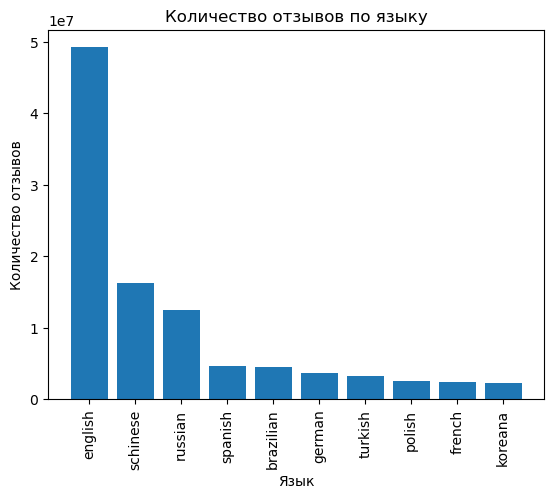

In [16]:
make_barplot('language', 'Count', sorted_lang_df, 
             'Язык', 'языку', rotation=True)

### voted_up

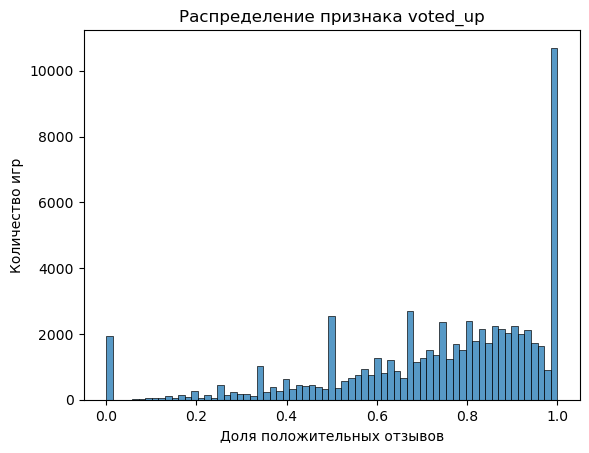

In [17]:
make_histplot('voted_up', df, 'Доля положительных отзывов', rotation=False)

**В основном отзывы в датасете положительные**

In [18]:
# Топ-10 игр по отзывам
df_games.sort_values(by='voted_up', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
36559,1012600,Why Chicken? Why?,1,0,1.0,0.000000,0.000000,0.0,0.000000,2.000000,26.000000,0.000000,26.000000
10360,925050,Crystal Path,4,0,1.0,1.000000,0.000000,0.0,207.833333,51.500000,1763.166667,217.833333,1256.833333
60988,1253010,Stella Pastoris,2,0,1.0,0.833333,0.000000,0.0,183.500000,15.500000,75.500000,0.000000,70.666667
60984,2107480,Hypogean,1,0,1.0,1.000000,0.000000,0.0,0.000000,1.000000,159.000000,0.000000,130.000000
20970,1735090,Tea Time,2,0,1.0,0.800000,0.000000,0.0,41.400000,34.200000,170.000000,0.000000,101.800000
60982,2129410,Salt Game,0,0,1.0,1.000000,0.000000,0.0,99.666667,4.333333,879.333333,0.000000,126.666667
42593,623470,League of Light: Wicked Harvest Collector's Ed...,5,0,1.0,0.800000,0.000000,0.0,23.200000,566.000000,612.600000,0.000000,399.600000
29025,1883750,Woodle Tree 2: Deluxe Plus,29,0,1.0,0.666667,0.166667,0.0,1544.066667,219.533333,268.833333,0.000000,184.133333
24718,1675110,My Downtown,3,0,1.0,1.000000,0.000000,0.0,0.000000,74.750000,732.000000,0.000000,248.500000
47637,1949490,YUMMY CHICKEN DRAGON,12,0,1.0,0.722222,0.111111,0.0,198.444444,17.388889,96.500000,0.000000,62.833333


**Важно учитывать, что места "в топе" могут занять игры, у которых всего 1-2 положительных отзыва**

### steam_purchase

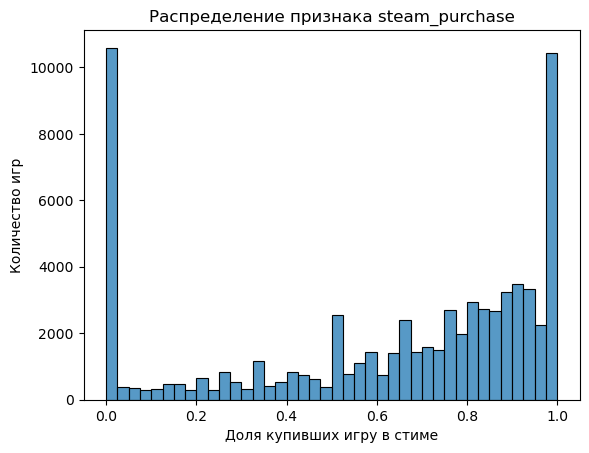

In [19]:
make_histplot('steam_purchase', df, 'Доля купивших игру в стиме', rotation=False)

**В основном игры покупаются на стиме, но много отзывов и на игры, которые были куплены вне стима**

In [20]:
# Топ-10 игр по покупаемости на стиме
df_games.sort_values(by='steam_purchase', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
17080,726230,The Superlatives: Aetherfall,22,2,0.880000,1.0,0.000000,0.0,178.960000,38.800000,978.800000,0.0,NaN
8110,1704620,Harrier Jump Jet,1,0,1.000000,1.0,0.000000,0.0,1056.500000,1233.000000,10.000000,0.0,10.000000
52306,764720,Oh No! Ninjas!,2,0,0.666667,1.0,0.000000,0.0,2856.666667,3485.000000,21.000000,0.0,21.000000
57693,1726590,Marble Mage,8,1,0.909091,1.0,0.000000,0.0,328.727273,53.000000,622.090909,0.0,168.818182
64572,2279270,The Duduk Master,0,0,0.000000,1.0,0.000000,0.0,150.000000,25.000000,25.000000,0.0,25.000000
45431,1371110,labyrinth 2,5,0,1.000000,1.0,0.000000,0.0,189.250000,45.750000,61.750000,0.0,32.000000
64569,2269350,MrWang And Love,0,0,0.166667,1.0,0.000000,0.0,470.166667,36.833333,260.166667,0.0,189.500000
52303,498460,Abduction Prologue: The Story Of Jonathan Blake,1,10,0.090909,1.0,0.090909,0.0,795.636364,577.181818,26.727273,0.0,21.181818
45435,1573330,Unreal Sandbox,2,1,0.666667,1.0,0.000000,0.0,49.000000,15.666667,203.000000,0.0,38.333333
64566,2296270,Sex Adventures - The Job Promotion,0,0,0.500000,1.0,0.000000,0.0,0.000000,1535.000000,12.000000,0.0,11.500000


### received_for_free

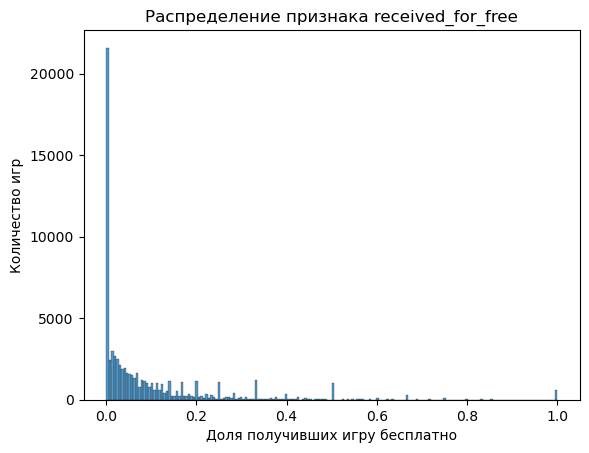

In [21]:
make_histplot('received_for_free', df, 'Доля получивших игру бесплатно', rotation=False)

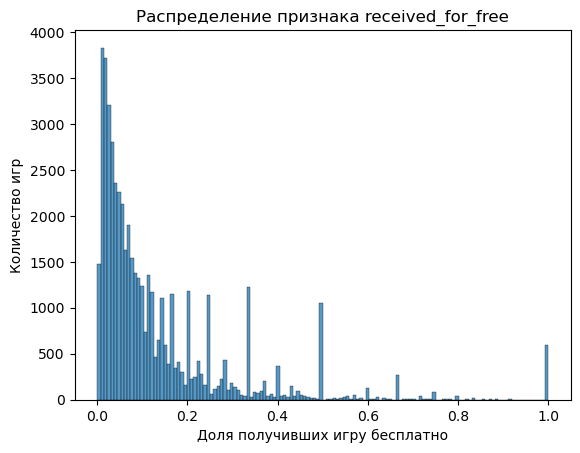

In [22]:
make_histplot('received_for_free', df[df['received_for_free'] > 0], 
              'Доля получивших игру бесплатно', rotation=False)

**В основном люди покупают игры, а не получают их бесплатно**

In [23]:
# Топ-10 игр по количеству получающих их бесплатно людей
df_games.sort_values(by='received_for_free', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
26479,994170,Statue Defender,1,1,0.50,0.0,1.0,0.00,1029.00,2265.00,26.0,0.0,13.0
50353,1241810,Bowmen,1,0,1.00,0.0,1.0,1.00,0.00,1.00,76.0,0.0,41.0
4701,1241690,Fatal Wings,1,0,1.00,0.0,1.0,0.00,0.00,12.00,45.0,0.0,37.0
64142,2234610,winVGF,0,0,0.00,0.0,1.0,0.00,1297.00,36.00,6.0,0.0,6.0
50503,1354970,DNA Farm,1,0,1.00,0.0,1.0,0.00,630.00,1037.00,8.0,0.0,8.0
50481,1192950,Qi Qiang,2,1,0.50,0.0,1.0,0.00,1139.50,2273.50,144.5,0.0,124.5
4654,1526360,Customers From Hell - Game For Retail Workers ...,1,0,0.75,0.0,1.0,0.25,816.25,553.25,32.5,0.0,32.5
40977,1559770,Microgravity,0,1,0.00,0.0,1.0,0.00,935.00,138.00,7.0,0.0,7.0
64205,2252870,Tactical Vengeance: Play The Game,0,0,1.00,0.0,1.0,1.00,55.00,1.00,350.0,17.0,23.0
4630,1354800,Really Bad Flying Machine,1,0,1.00,0.0,1.0,0.00,11.00,4.00,494.0,0.0,32.0


### written_during_early_access

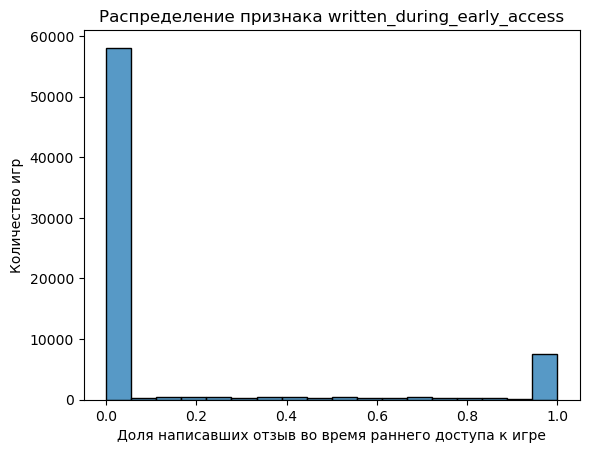

In [24]:
make_histplot('written_during_early_access', df, 
              'Доля написавших отзыв во время раннего доступа к игре', 
              rotation=False)

**Основная часть отзывов написана не во время раннего доступа к игре**

In [25]:
# Топ-10 игр по количеству отзывов, написанных во время раннего доступа к игре
df_games.sort_values(by='written_during_early_access', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
67792,1267210,Together in Battle,7,1,0.916667,0.916667,0.083333,1.0,256.750000,43.916667,1856.833333,48.333333,1148.625000
66773,1915510,Yao-Guai Hunter,0,0,0.842885,0.910079,0.025692,1.0,134.513834,31.266798,1932.063241,40.339921,796.162055
18847,1672930,梅斯特姆,6,8,0.470588,1.000000,0.000000,1.0,181.647059,12.176471,277.117647,2.941176,110.823529
35658,719470,Demon And Fairy,7,9,0.470588,0.941176,0.058824,1.0,797.823529,251.176471,113.705882,0.000000,99.411765
11047,943590,BlitzKeep Unleashed,6,1,0.857143,0.714286,0.285714,1.0,615.857143,388.428571,236.142857,0.000000,167.142857
5365,365290,House of Nightmares B-Movie Edition,3,1,0.600000,0.600000,0.000000,1.0,1158.600000,140.800000,42.600000,0.000000,42.400000
66777,774801,Crab Champions,1211,19,0.948980,0.887755,0.040816,1.0,60.724490,10.193878,2299.795918,670.959184,2095.683673
26836,1499750,The Frost Rebirth,8,15,0.400000,0.600000,0.200000,1.0,937.080000,115.600000,136.280000,1.800000,110.440000
62194,1955100,怯懦 Cowardice,3,0,0.750000,0.750000,0.000000,1.0,1731.750000,844.000000,31.000000,0.000000,31.000000
31954,761880,The Day They Landed,1,3,0.250000,0.250000,0.750000,1.0,1533.500000,269.750000,99.250000,0.000000,26.250000


### author_num_games_owned

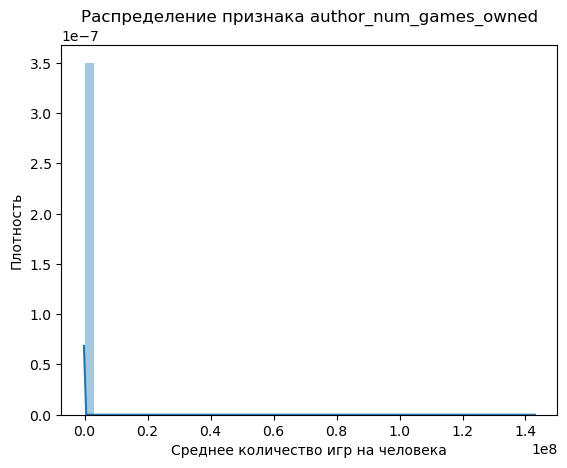

In [26]:
make_distplot('author_num_games_owned', df, 'Среднее количество игр на человека', rotation=False)

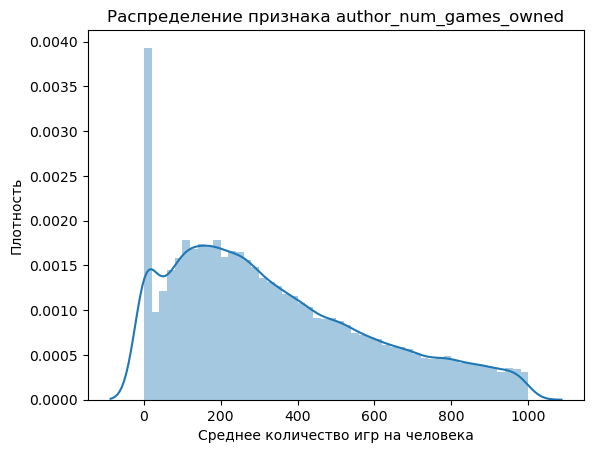

In [27]:
make_distplot('author_num_games_owned', df[df['author_num_games_owned'] < 1000], 
              'Среднее количество игр на человека', rotation=False)

**Видим по графикам, что среднее количество игр на человека может составлять и 1000, и более. Скорее всего в данных есть выбросы и много**

In [28]:
lower_bound = df['author_num_games_owned'].quantile(q=0.025)
upper_bound = df['author_num_games_owned'].quantile(q=0.975)
print('Количество выбросов по межквантильному критерию:', 
      len(df[(df['author_num_games_owned'] < lower_bound) | (df['author_num_games_owned'] > upper_bound)]),
     '\nДоля выбросов:', 
      100*len(df[(df['author_num_games_owned'] < lower_bound) | (df['author_num_games_owned'] > upper_bound)])/len(df), '%')

Количество выбросов по межквантильному критерию: 1779 
Доля выбросов: 2.500421656265812 %


In [29]:
# Топ-10 игр по количеству отзывов от людей, владеющих большим количеством игр
df_games.sort_values(by='author_num_games_owned', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
630,40800,Super Meat Boy,28651,1554,0.947503,0.745601,0.011298,0.0,1.427847e+08,25.192877,1212.256250,9.692812,NaN
26441,1158310,Crusader Kings III,71574,5380,0.918812,0.655040,0.012814,0.0,4.423583e+07,11.671002,12673.198696,297.739346,6539.552870
9500,236850,Europa Universalis IV,93164,14604,0.867716,0.684575,0.011673,0.0,3.535675e+07,9.387239,52847.411083,420.271877,NaN
56771,48700,Mount & Blade: Warband,140048,3220,0.976784,0.803269,0.012464,0.0,2.808203e+07,11.767315,20536.570290,98.082138,NaN
32034,945360,Among Us,577656,51069,0.921361,0.880042,0.044690,0.0,6.160124e+06,6.955957,2681.040410,62.709188,1446.397225
43279,1787140,RagingFist,0,0,0.000000,1.000000,0.000000,0.0,3.000000e+04,171.000000,40.000000,0.000000,40.000000
3533,1195250,Gateball VR,0,1,0.000000,1.000000,0.000000,0.0,2.556100e+04,270.000000,16.000000,0.000000,16.000000
68113,2363670,Watchers of the Universe: I'm outta here!,0,0,1.000000,0.000000,1.000000,0.0,2.091200e+04,254.000000,330.000000,0.000000,330.000000
60531,2086090,Violet's Party Mania,1,0,1.000000,0.000000,1.000000,0.0,2.091100e+04,254.000000,274.000000,0.000000,274.000000
59442,1710790,Finley's - The Colour of Radiation,0,0,1.000000,0.000000,1.000000,0.0,2.091100e+04,254.000000,112.000000,0.000000,93.000000


### author_num_reviews

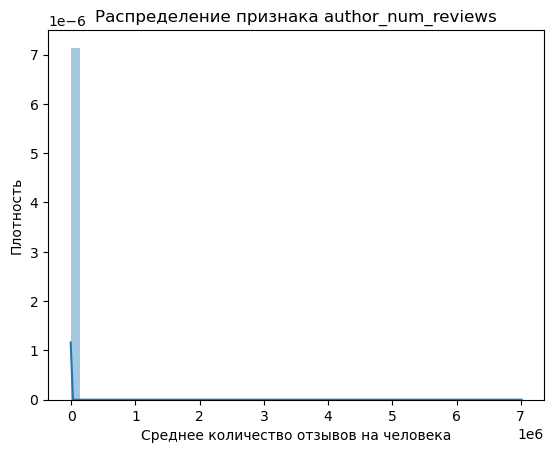

In [30]:
make_distplot('author_num_reviews', df, 'Среднее количество отзывов на человека', rotation=False)

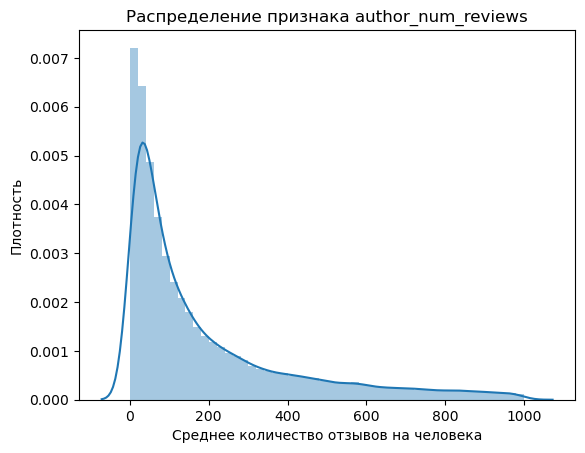

In [31]:
make_distplot('author_num_reviews', df[df['author_num_reviews'] < 1000], 
              'Среднее количество отзывов на человека', rotation=False)

**В основном люди пишут менее 200 отзывов. Однако мы видим, что есть значения и в 1000 отзывов, и более, что означает наличие выбросов**

In [32]:
lower_bound = df['author_num_reviews'].quantile(q=0.025)
upper_bound = df['author_num_reviews'].quantile(q=0.975)
print('Количество выбросов по межквантильному критерию:', 
      len(df[(df['author_num_reviews'] < lower_bound) | (df['author_num_reviews'] > upper_bound)]),
     '\nДоля выбросов:', 
      100*len(df[(df['author_num_reviews'] < lower_bound) | (df['author_num_reviews'] > upper_bound)])/len(df), '%')

Количество выбросов по межквантильному критерию: 3506 
Доля выбросов: 4.927756226457525 %


In [33]:
# Топ-10 игр, на которые отзывы писали люди, которые в целом пишут очень много отзывов
df_games.sort_values(by='author_num_reviews', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
57077,413150,Stardew Valley,475785,8983,0.980743,0.846578,0.020197,0.0,96.744012,7.003545e+06,NaN,NaN,NaN
54014,271590,Grand Theft Auto V,1171197,210154,0.857158,0.908470,0.042772,0.0,63.136644,2.585757e+06,18596.801689,237.419697,NaN
62066,2197170,Aswang Detective: The Case of New York,0,0,0.000000,0.000000,0.000000,0.0,8529.000000,1.043600e+04,13.000000,0.000000,13.0
47327,1913020,Astra Wing,0,0,0.000000,1.000000,0.000000,0.0,8529.000000,1.043600e+04,244.000000,0.000000,244.0
28767,1168160,Piping Hot,0,0,0.000000,0.000000,0.000000,0.0,8529.000000,1.043600e+04,14.000000,0.000000,14.0
35441,1308450,Halloween Horrors Deluxe Steam Edition,0,0,0.000000,0.000000,0.000000,0.0,8529.000000,1.043600e+04,5.000000,0.000000,5.0
5454,1976590,Eternal Space,0,0,0.000000,0.000000,0.000000,1.0,8529.000000,1.043600e+04,493.000000,0.000000,87.0
64299,2267010,Kong Hero,0,0,0.000000,0.000000,0.000000,1.0,8529.000000,1.043600e+04,38.000000,0.000000,38.0
24085,854530,Paper Shakespeare: Stick Julius Caesar (with a...,0,0,0.000000,0.000000,0.000000,0.0,8529.000000,1.043400e+04,8.000000,0.000000,8.0
63531,2239250,Space Fighter,0,0,0.000000,0.000000,0.000000,1.0,8529.000000,1.043400e+04,41.000000,0.000000,41.0


### author_playtime_forever

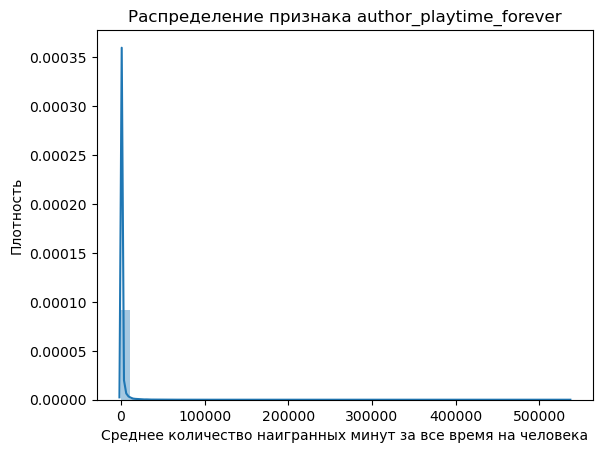

In [34]:
make_distplot('author_playtime_forever', df, 
              'Среднее количество наигранных минут за все время на человека', rotation=False)

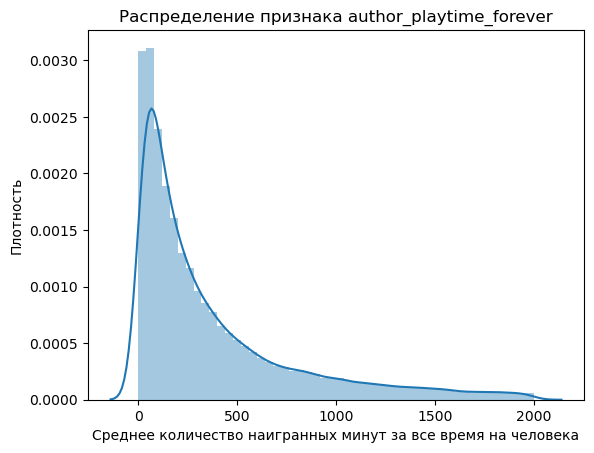

In [35]:
make_distplot('author_playtime_forever', df[df['author_playtime_forever'] < 2000], 
              'Среднее количество наигранных минут за все время на человека', rotation=False)

**В основном люди наигрывают до 500 минут в одной игре, также есть выбросы**

In [36]:
lower_bound = df['author_playtime_forever'].quantile(q=0.025)
upper_bound = df['author_playtime_forever'].quantile(q=0.975)
print('Количество выбросов по межквантильному критерию:', 
      len(df[(df['author_playtime_forever'] < lower_bound) | (df['author_playtime_forever'] > upper_bound)]),
     '\nДоля выбросов:', 
      100*len(df[(df['author_playtime_forever'] < lower_bound) | (df['author_playtime_forever'] > upper_bound)])/len(df), '%')

Количество выбросов по межквантильному критерию: 3475 
Доля выбросов: 4.884185078990273 %


In [37]:
# Топ-10 игр по количеству времени, которое игроки в них проводят
df_games.sort_values(by='author_playtime_forever', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
15658,1427540,Attack from Planet Smiley,1,0,1.000000,1.000000,0.000000,0.0,179.000000,28.000000,535126.000000,2951.000000,41741.000000
27938,1912760,The Hentai Memory,0,0,0.793103,0.086207,0.068966,0.0,320.672414,216.431034,461955.362069,5667.155172,31655.068966
14669,466170,Idling to Rule the Gods,1124,161,0.872258,0.010968,0.057419,0.0,223.584516,74.887097,289746.129677,1395.238710,NaN
56694,402840,Crusaders of the Lost Idols,2348,455,0.832050,0.016795,0.025892,0.0,493.899930,76.994052,230394.385584,231.775367,NaN
47,718350,Loot Collection: Mahjong,2,3,0.500000,1.000000,0.000000,0.0,1888.250000,1668.250000,218959.875000,0.000000,96636.000000
16756,663090,Granado Espada,594,396,0.617569,0.059450,0.086957,0.0,68.740018,71.780834,213534.001775,758.241349,NaN
37723,946400,Slime Quest,5,2,0.714286,0.428571,0.142857,0.0,390.142857,614.000000,213395.714286,0.000000,16617.571429
9321,1011510,Wizard And Minion Idle,539,57,0.910355,0.000000,0.040185,0.0,242.545595,95.981453,211040.615147,476.683153,NaN
55747,805470,CubicPanic,1,0,1.000000,1.000000,0.000000,0.0,0.000000,2385.000000,194999.000000,0.000000,77.000000
9770,1147690,NGU IDLE,8577,332,0.962300,0.000000,0.069052,0.0,199.508271,25.319196,170514.340739,784.731583,52354.621562


### author_playtime_last_two_weeks

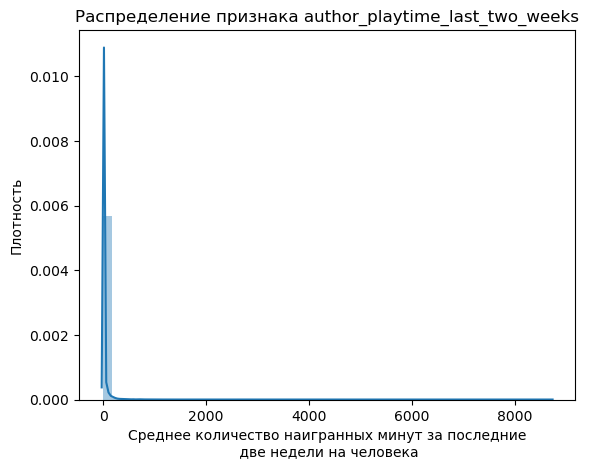

In [38]:
make_distplot('author_playtime_last_two_weeks', df, 
              'Среднее количество наигранных минут за последние\n две недели на человека', rotation=False)

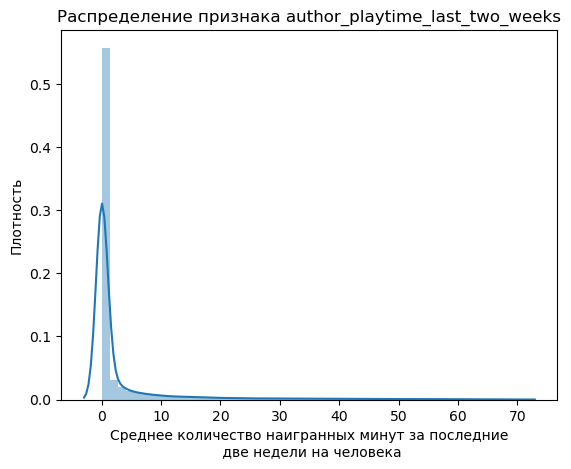

In [39]:
make_distplot('author_playtime_last_two_weeks', df[df['author_playtime_last_two_weeks'] < 70], 
              'Среднее количество наигранных минут за последние\n две недели на человека', rotation=False)

**В основном за последние две недели количество наигранных минут не превышает 30, что нормально, но немного выбросов есть и здесь**

In [40]:
lower_bound = df['author_playtime_last_two_weeks'].quantile(q=0.025)
upper_bound = df['author_playtime_last_two_weeks'].quantile(q=0.975)
print('Количество выбросов по межквантильному критерию:', 
      len(df[(df['author_playtime_last_two_weeks'] < lower_bound) | (df['author_playtime_last_two_weeks'] > upper_bound)]),
     '\nДоля выбросов:', 
      100*len(df[(df['author_playtime_last_two_weeks'] < lower_bound) | (df['author_playtime_last_two_weeks'] > upper_bound)])/len(df), '%')

Количество выбросов по межквантильному критерию: 1779 
Доля выбросов: 2.500421656265812 %


In [41]:
# Топ-10 игр по количеству времени, которое игроки в них проводили последние две недели
df_games.sort_values(by='author_playtime_last_two_weeks', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
17770,1661690,Inflatable doll,8,10,0.971698,0.968553,0.018868,0.0,100.962264,45.393082,9117.814465,8703.066038,225.487421
70994,2496860,修仙小屋,0,0,0.751724,0.000000,0.158621,0.0,109.213793,30.006897,39773.234483,5671.689655,8980.331034
67813,2389930,"Ayase, the Sexy Archer",0,0,0.962963,0.814815,0.018519,0.0,235.129630,92.981481,41606.037037,5667.425926,2560.611111
27938,1912760,The Hentai Memory,0,0,0.793103,0.086207,0.068966,0.0,320.672414,216.431034,461955.362069,5667.155172,31655.068966
907,1102140,Glizzy Gobbler,1,0,0.750000,1.000000,0.000000,0.0,75.500000,10.750000,12582.250000,4980.500000,3477.000000
43614,1283970,YoloMouse,902,67,0.938874,0.977335,0.005495,0.0,169.578984,12.688187,138426.622940,3079.730769,62113.324863
62031,2115630,CyberLink PowerDirector 21 Ultimate,0,0,0.800000,1.000000,0.000000,0.0,48.400000,5.600000,13442.800000,3025.800000,7405.600000
15658,1427540,Attack from Planet Smiley,1,0,1.000000,1.000000,0.000000,0.0,179.000000,28.000000,535126.000000,2951.000000,41741.000000
17671,1962930,Jacks or Better - Video Poker,1,0,1.000000,0.714286,0.285714,0.0,1269.571429,191.000000,54397.000000,2875.142857,356.285714
57738,1950140,SAVE THE SCHOOL FLOWER ACTION,3,3,0.500000,0.666667,0.333333,0.0,668.500000,112.666667,82881.000000,2692.666667,587.000000


### author_playtime_at_review

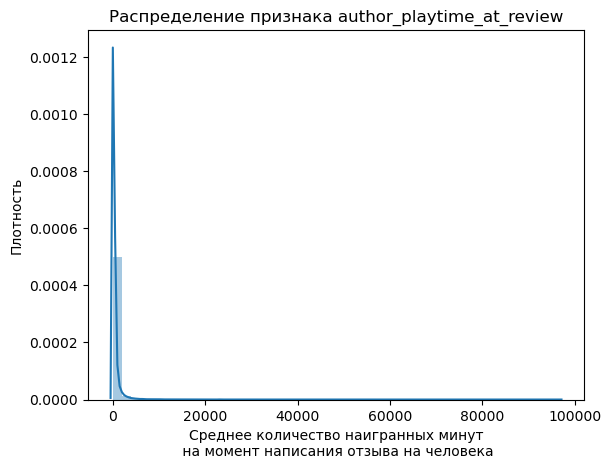

In [42]:
make_distplot('author_playtime_at_review', df, 
              'Среднее количество наигранных минут\n на момент написания отзыва на человека', 
              rotation=False)

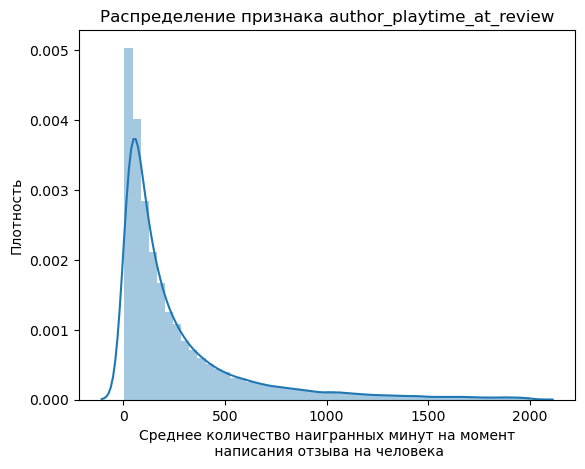

In [43]:
make_distplot('author_playtime_at_review', df[df['author_playtime_at_review'] < 2000], 
              'Среднее количество наигранных минут на момент\n написания отзыва на человека', 
              rotation=False)

In [44]:
lower_bound = df['author_playtime_at_review'].quantile(q=0.025)
upper_bound = df['author_playtime_at_review'].quantile(q=0.975)
print('Количество выбросов по межквантильному критерию:', 
      len(df[(df['author_playtime_at_review'] < lower_bound) | (df['author_playtime_at_review'] > upper_bound)]),
     '\nДоля выбросов:', 
      100*len(df[(df['author_playtime_at_review'] < lower_bound) | (df['author_playtime_at_review'] > upper_bound)])/len(df), '%')

Количество выбросов по межквантильному критерию: 3095 
Доля выбросов: 4.350087142294934 %


In [45]:
# Топ-10 игр по количеству времени, которое игроки в них провели на момент написания отзыва
df_games.sort_values(by='author_playtime_at_review', ascending=False)[:10]

,AppID,Name,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
47,718350,Loot Collection: Mahjong,2,3,0.500000,1.000000,0.000000,0.000000,1888.250000,1668.250000,218959.875000,0.000000,96636.000000
22196,530300,Slymes,6,1,0.857143,0.714286,0.000000,0.000000,664.857143,266.571429,90683.857143,0.000000,89989.571429
52329,1081100,Insurgence - Second Assault,19,0,1.000000,0.789474,0.105263,0.000000,248.631579,131.684211,90110.789474,783.473684,72540.842105
43614,1283970,YoloMouse,902,67,0.938874,0.977335,0.005495,0.000000,169.578984,12.688187,138426.622940,3079.730769,62113.324863
39134,25860,Sword of the Stars: Complete Collection,369,49,0.500000,1.000000,0.000000,0.000000,0.000000,10.000000,66074.750000,0.000000,61647.250000
40341,1269900,snake::reloaded,0,0,1.000000,1.000000,0.000000,0.000000,6700.000000,61.000000,60007.000000,0.000000,60007.000000
45177,38020,Mahjong Quest Collection,20,2,1.000000,1.000000,0.000000,0.000000,28.333333,4.333333,83203.222222,44.333333,57782.444444
9770,1147690,NGU IDLE,8577,332,0.962300,0.000000,0.069052,0.000000,199.508271,25.319196,170514.340739,784.731583,52354.621562
47714,468070,90 Minute Fever - Online Football (Soccer) Man...,155,95,0.638989,0.379061,0.054152,0.963899,280.480144,194.613718,113116.602888,260.411552,44270.584838
52673,933540,Idle Space Raider,153,52,0.744186,0.000000,0.041860,0.000000,442.176744,219.948837,111855.632558,50.241860,41817.386047


## Корреляционный анализ

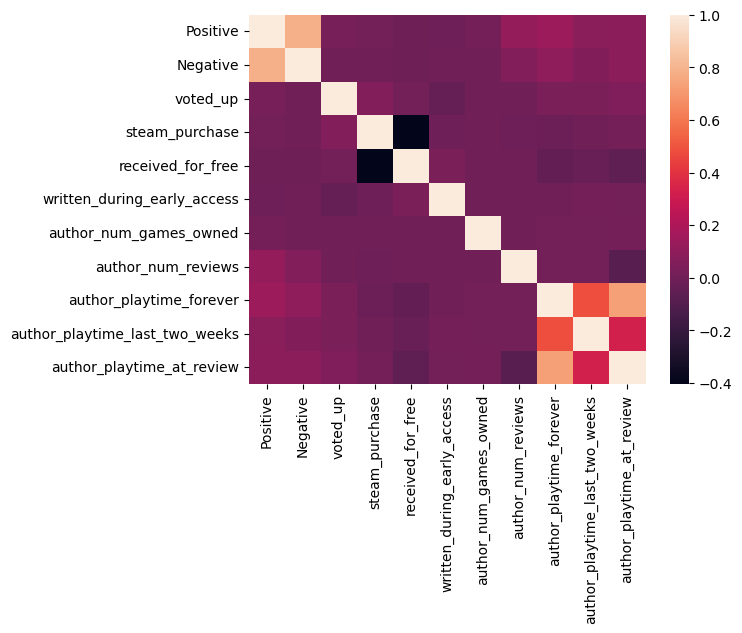

In [46]:
corr_matrix = df_games.iloc[:, 2:].corr()
sns.heatmap(corr_matrix)
plt.show()

## Построим графики скоррелированных признаков

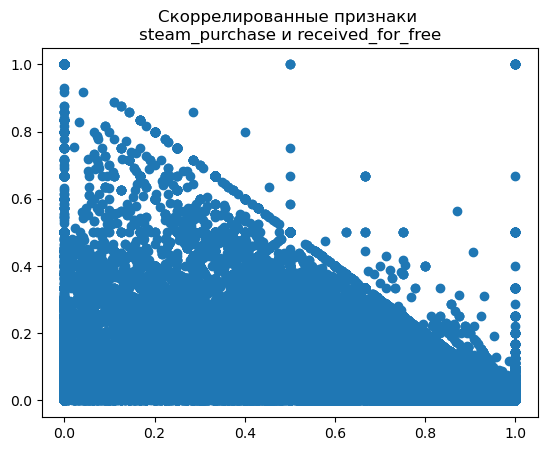

In [47]:
plot_correlated_features('steam_purchase', 'received_for_free', df_games)

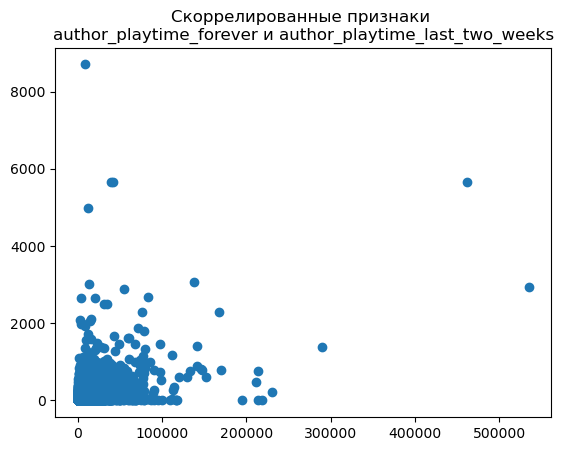

In [48]:
plot_correlated_features('author_playtime_forever', 'author_playtime_last_two_weeks', df_games)

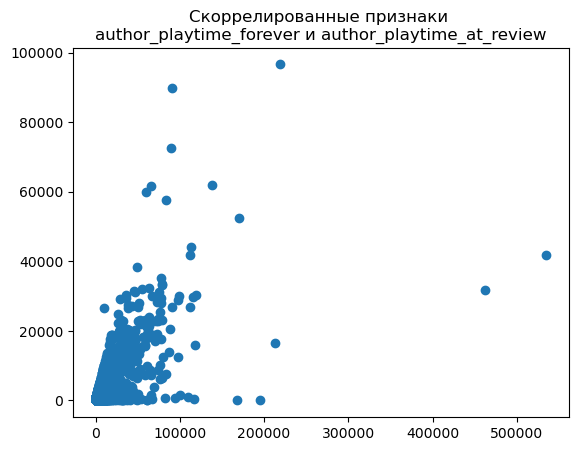

In [49]:
plot_correlated_features('author_playtime_forever', 'author_playtime_at_review', df_games)

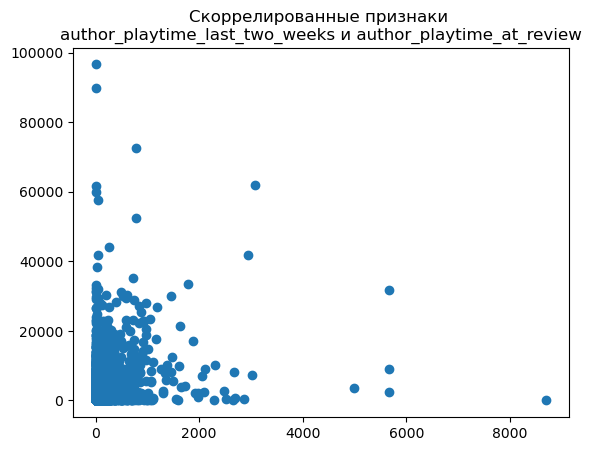

In [50]:
plot_correlated_features('author_playtime_last_two_weeks', 'author_playtime_at_review', df_games)

## Выводы

- необходима обработка выбросов
- видим, что люди играют во множество игр и пишут много отзывов, поэтому может быть целесообразно оставлять для дальнейшего моделирования только наиболее активных пользователей и наиболее востребованные игры
- есть скоррелированные признаки, но немного, необходимо выбрать один из скоррелированных признаков при построении моделей

# Дополнительный анализ при estimated owners более 50.000 пользователей

In [54]:
df_games["TotalReviews"] = df_games["Positive"] + df_games["Negative"]

df_popular = df_games.query("TotalReviews >= 400")

In [55]:
df_popular.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,TotalReviews
count,8.508000e+03,8.508000e+03,8508.000000,8508.000000,8508.000000,8508.000000,8508.000000,8.508000e+03,8.508000e+03,8496.000000,8496.000000,3831.000000,8.508000e+03
mean,6.769484e+05,8.949097e+03,1415.265397,0.811317,0.672107,0.034745,0.120977,3.047285e+04,1.184173e+03,3836.620440,27.458305,1526.257671,1.036436e+04
std,4.660049e+05,7.621376e+04,14313.242310,0.136550,0.310573,0.042230,0.284227,1.694036e+06,8.093429e+04,9826.074676,84.489396,3096.546701,8.784790e+04
min,1.000000e+01,6.200000e+01,0.000000,0.105035,0.000000,0.000000,0.000000,0.000000e+00,3.100782e+00,0.001074,0.000000,10.787509,4.000000e+02
1%,3.720700e+03,2.180700e+02,15.000000,0.362754,0.000000,0.002350,0.000000,4.788202e+01,8.071449e+00,85.743615,0.000000,52.308535,4.080000e+02
5%,3.408600e+04,3.190000e+02,35.350000,0.535672,0.000000,0.005757,0.000000,8.063605e+01,1.306109e+01,229.601573,0.017269,124.544383,4.430000e+02
10%,2.098180e+05,3.770000e+02,55.000000,0.620667,0.013895,0.007759,0.000000,1.048705e+02,1.669945e+01,333.472180,0.135744,198.227941,4.887000e+02
25%,3.113850e+05,5.370000e+02,109.000000,0.744560,0.593192,0.012307,0.000000,1.659991e+02,2.551805e+01,632.384285,1.235150,382.323903,6.780000e+02
50%,5.537250e+05,1.125500e+03,235.000000,0.845618,0.795573,0.021332,0.000000,2.669782e+02,4.339323e+01,1370.972531,5.998051,745.229400,1.395000e+03
75%,1.025418e+06,3.472500e+03,616.000000,0.914488,0.893862,0.040201,0.000000,4.122124e+02,7.419272e+01,3338.350365,21.602262,1527.463244,4.180250e+03


In [57]:
df_games.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,AppID,Positive,Negative,voted_up,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,TotalReviews
count,7.114800e+04,7.114800e+04,71148.000000,71148.000000,71148.000000,71148.000000,71148.000000,7.114800e+04,7.114800e+04,71135.000000,71135.000000,61919.000000,7.114800e+04
mean,1.226345e+06,1.097078e+03,178.033564,0.740584,0.625439,0.093067,0.140561,4.291347e+03,4.788559e+02,1287.229734,10.946197,449.447866,1.275111e+03
std,6.291145e+05,2.651226e+04,4970.349916,0.235482,0.346179,0.150691,0.325188,5.858577e+05,2.799471e+04,5819.748655,85.242599,1561.888567,3.056097e+04
min,1.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,0.001074,0.000000,5.000000,0.000000e+00
1%,3.385580e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,9.000000,0.000000,8.000000,0.000000e+00
5%,3.019135e+05,0.000000e+00,0.000000,0.267072,0.000000,0.000000,0.000000,0.000000e+00,8.000000e+00,21.566667,0.000000,16.300000,0.000000e+00
10%,3.989270e+05,0.000000e+00,0.000000,0.417220,0.000000,0.000000,0.000000,6.120458e+01,1.600000e+01,37.122727,0.000000,25.714286,0.000000e+00
25%,7.011450e+05,1.000000e+00,0.000000,0.621193,0.389455,0.000000,0.000000,1.739134e+02,4.100000e+01,93.202273,0.000000,58.000000,2.000000e+00
50%,1.190085e+06,1.000000e+01,3.000000,0.800000,0.750000,0.036145,0.000000,3.829989e+02,1.186090e+02,264.017953,0.000000,144.031250,1.400000e+01
75%,1.731600e+06,6.100000e+01,18.000000,0.922731,0.911864,0.114286,0.000000,8.168813e+02,3.565890e+02,773.423706,1.272215,362.061522,8.400000e+01


**Выводы:**
- Для популярных игр меньше доля людей, получивших их бесплатно
- Также меньше и доля людей, написавших отзывы во время раннего доступа к игре
- Для популярных игр больше количество игр, в которые авторы отзывов играют, и количество отзывов, которые люди пишут
- Для популярных игр больше время, которое люди играют в них вообще и на момент написания отзыва

In [58]:
language_counter = FeatureCounter('language', 4, condition=True)
dict_languages = language_counter.get_all_feature_counts()

sorted_lang = sorted(dict_languages.items(), key=lambda item: item[1], reverse=True)
sorted_lang_df = pd.DataFrame(sorted_lang[0:10], columns=['language', 'Count'])

Total time: 4.395503044128418


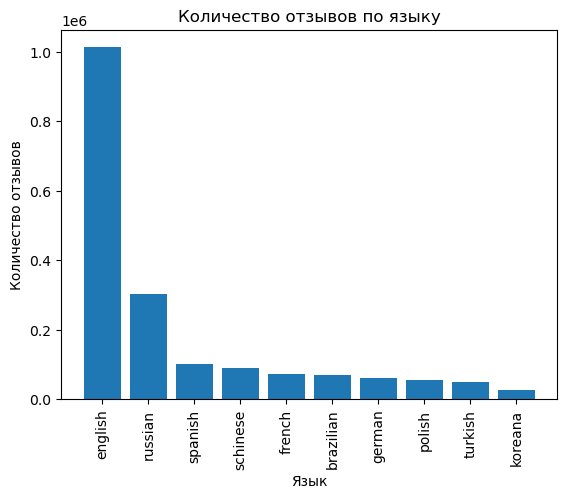

In [59]:
make_barplot('language', 'Count', sorted_lang_df, 
             'Язык', 'языку', rotation=True)

**Видим, что для популярных игр значительно больше отзывов на русском языке**

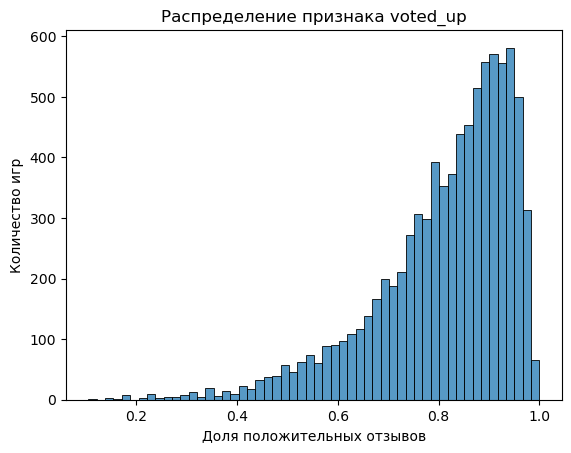

In [60]:
make_histplot('voted_up', df_popular, 'Доля положительных отзывов', rotation=False)

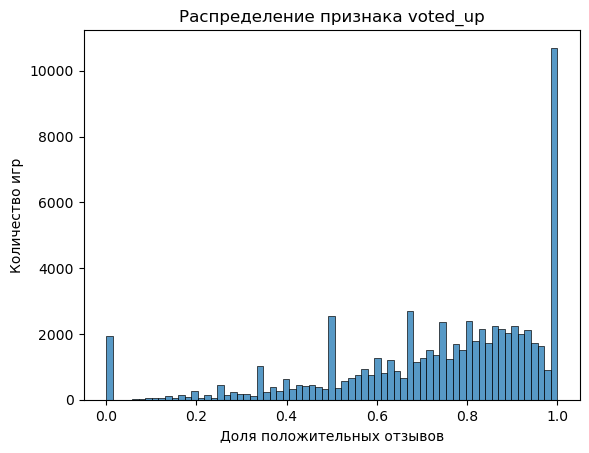

In [61]:
make_histplot('voted_up', df, 'Доля положительных отзывов', rotation=False)

**Видим, что для популярных игр более плавно распределена доля положительных отзывов. И в целом положительных отзывов больше**

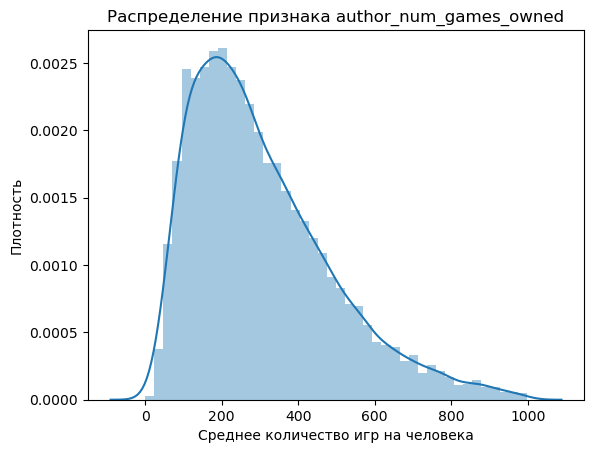

In [62]:
make_distplot('author_num_games_owned', df_popular[df_popular['author_num_games_owned'] < 1000], 
              'Среднее количество игр на человека', rotation=False)

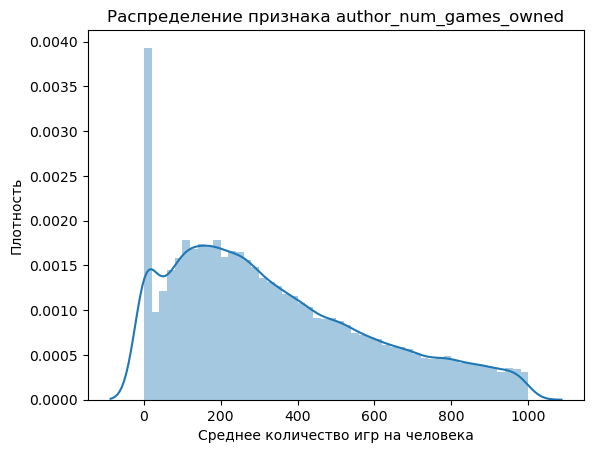

In [63]:
make_distplot('author_num_games_owned', df[df['author_num_games_owned'] < 1000], 
              'Среднее количество игр на человека', rotation=False)

**Видим, что для популярных игр меньше количество людей, которые играют в маленькое количество игр (около нуля)**

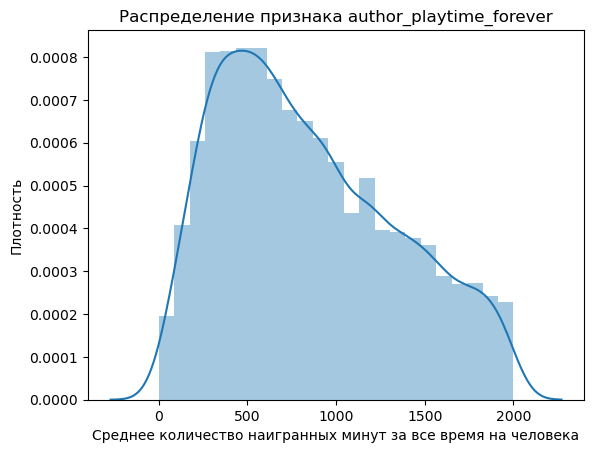

In [64]:
make_distplot('author_playtime_forever', df_popular[df_popular['author_playtime_forever'] < 2000], 
              'Среднее количество наигранных минут за все время на человека', rotation=False)

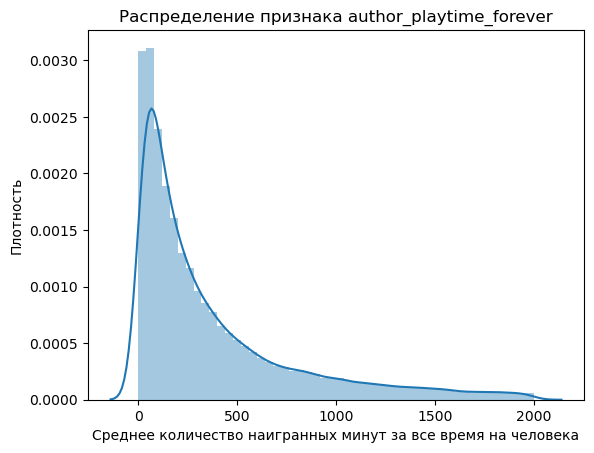

In [65]:
make_distplot('author_playtime_forever', df[df['author_playtime_forever'] < 2000], 
              'Среднее количество наигранных минут за все время на человека', rotation=False)

**Видим, что для популярных игр более плавно распределено время, которое они проводят в играх**

# 2 часть. Группировка по пользователям

## Сбор данных в один датафрейм

In [67]:
def get_data(feature_list, file_path: str):
    df = pd.read_csv(file_path)
    return df[['author_steamid'] + feature_list]

feature_list = ['voted_up', 'author_num_games_owned', 'author_num_reviews',
               'author_playtime_forever', 'author_playtime_last_two_weeks', 
                'author_playtime_at_review']

N_JOBS = 4
start_time = time.time()
games_language_counts = Parallel(n_jobs=N_JOBS)(
    delayed(get_data)(feature_list, game_file_path) for game_file_path in game_review_files)
end_time = time.time()
print("Total time:", end_time - start_time)

merged_df = pd.concat(games_language_counts[0:])

Total time: 220.3245279788971


In [68]:
df_users = merged_df.groupby(by=['author_steamid']).mean()

## Описательные статистики

In [69]:
df_users.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,voted_up,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review
count,2.693465e+07,2.693465e+07,2.693465e+07,2.693465e+07,2.693465e+07,2.692293e+07
mean,8.636858e-01,9.155000e+04,1.143034e+05,2.151464e+04,1.753052e+02,1.125054e+04
std,2.768066e-01,2.314067e+08,4.563553e+08,4.907206e+04,6.628503e+02,2.995895e+04
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
1%,0.000000e+00,0.000000e+00,1.000000e+00,4.052419e+01,0.000000e+00,2.400000e+01
5%,0.000000e+00,0.000000e+00,1.000000e+00,3.210000e+02,0.000000e+00,1.800000e+02
10%,5.000000e-01,0.000000e+00,1.000000e+00,6.850000e+02,0.000000e+00,3.070000e+02
25%,8.571429e-01,3.500000e+00,1.000000e+00,2.081333e+03,0.000000e+00,8.480000e+02
50%,1.000000e+00,1.900000e+01,1.666667e+00,6.400500e+03,0.000000e+00,2.657167e+03
75%,1.000000e+00,5.666667e+01,3.100000e+00,1.991777e+04,5.400000e+01,8.987250e+03


## Построение графиков распределения

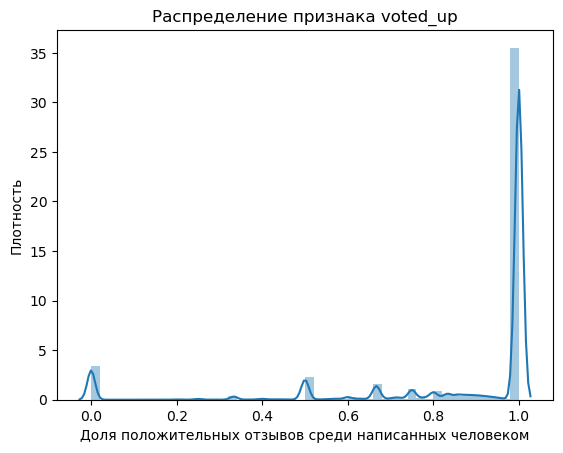

In [70]:
make_distplot('voted_up', df_users, 
              'Доля положительных отзывов среди написанных человеком', 
              rotation=False)

**Видим, что люди делятся на две группы: кто пишет только хорошие и только плохие отзывы. И первая группа больше**

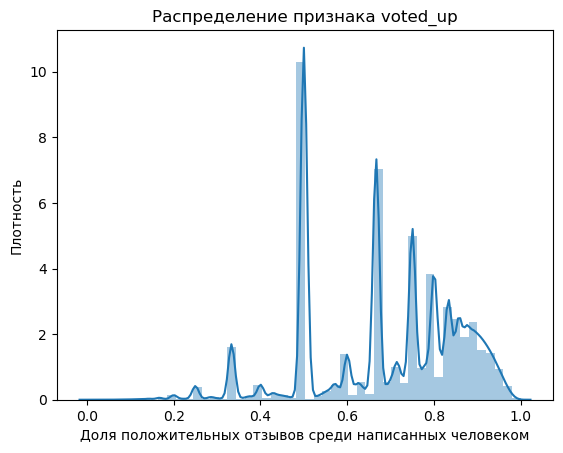

In [71]:
make_distplot('voted_up', df_users[(df_users['voted_up'] != 0) & (df_users['voted_up'] != 1)], 
              'Доля положительных отзывов среди написанных человеком', 
              rotation=False)

**Видим, что есть и группа людей, кто пишет и хорошие, и плохие отзывы, причем преобладают люд, которые пишут и те, и другие отзывы примерно поровну**

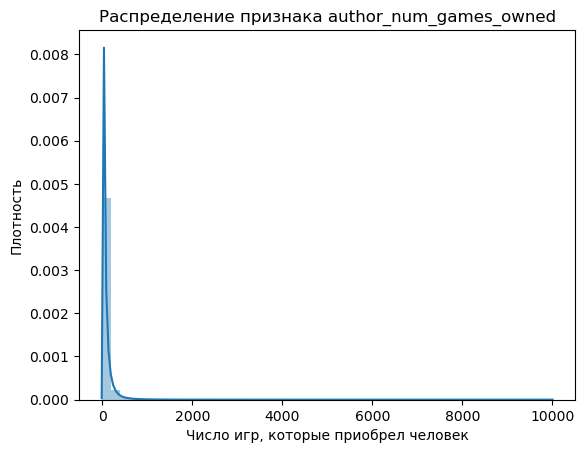

In [72]:
make_distplot('author_num_games_owned', 
              df_users[(df_users['author_num_games_owned'] != 0) & (df_users['author_num_games_owned'] < 10_000)], 
              'Число игр, которые приобрел человек', 
              rotation=False)

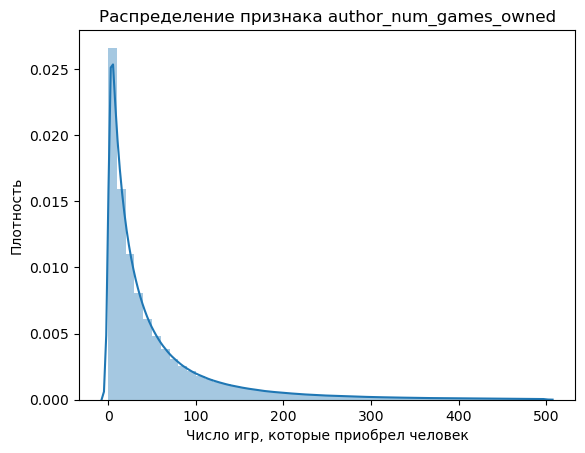

In [73]:
make_distplot('author_num_games_owned', 
              df_users[(df_users['author_num_games_owned'] != 0) & (df_users['author_num_games_owned'] < 500)], 
              'Число игр, которые приобрел человек', 
              rotation=False)

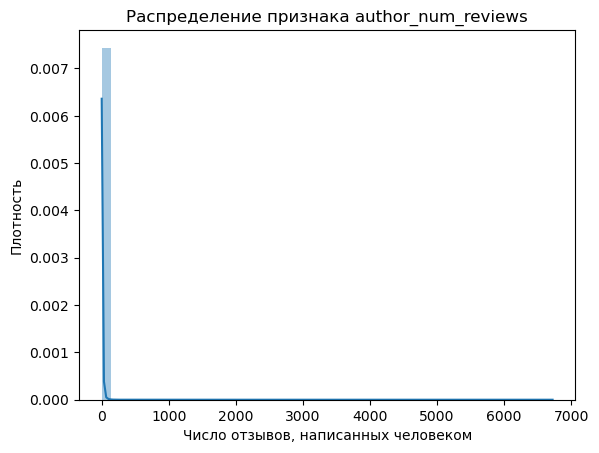

In [74]:
make_distplot('author_num_reviews', 
              df_users[(df_users['author_num_reviews'] != 0) & (df_users['author_num_reviews'] < 10_000)], 
              'Число отзывов, написанных человеком', 
              rotation=False)

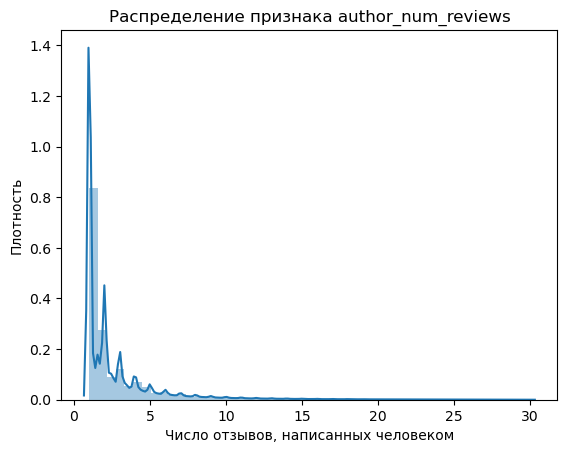

In [75]:
make_distplot('author_num_reviews', 
              df_users[(df_users['author_num_reviews'] != 0) & (df_users['author_num_reviews'] < 30)], 
              'Число отзывов, написанных человеком', 
              rotation=False)

**В основном один человек пишет до 5-10 отзывов**

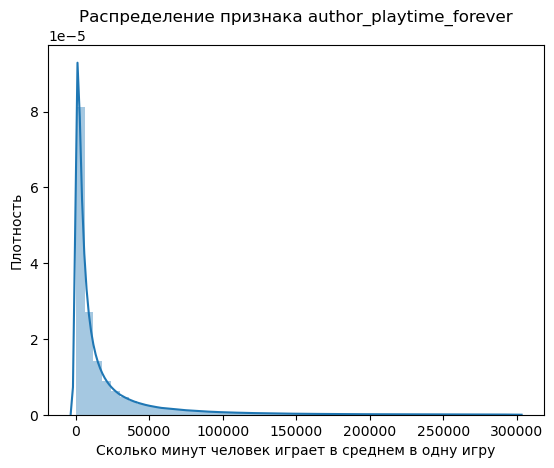

In [76]:
make_distplot('author_playtime_forever', 
              df_users[(df_users['author_playtime_forever'] != 0) & (df_users['author_playtime_forever'] < 300_000)], 
              'Сколько минут человек играет в среднем в одну игру', 
              rotation=False)

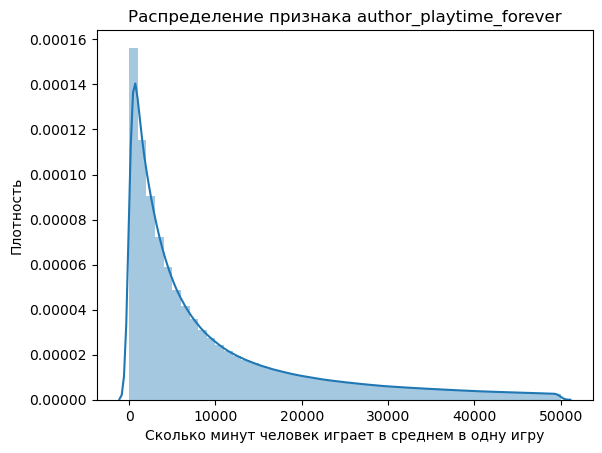

In [77]:
make_distplot('author_playtime_forever', 
              df_users[(df_users['author_playtime_forever'] != 0) & (df_users['author_playtime_forever'] < 50_000)], 
              'Сколько минут человек играет в среднем в одну игру', 
              rotation=False)

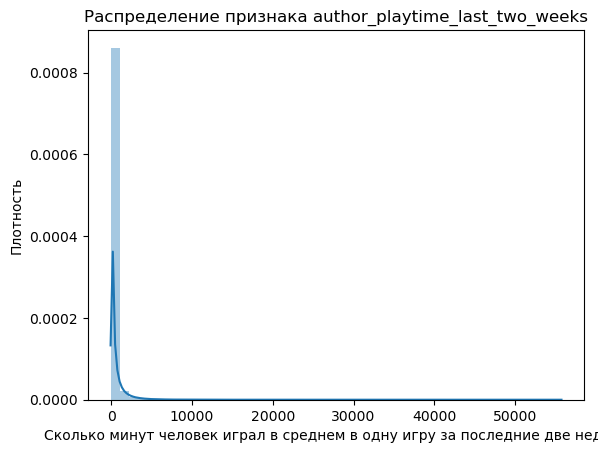

In [78]:
make_distplot('author_playtime_last_two_weeks', df_users, 
              'Сколько минут человек играл в среднем в одну игру за последние две недели', 
              rotation=False)

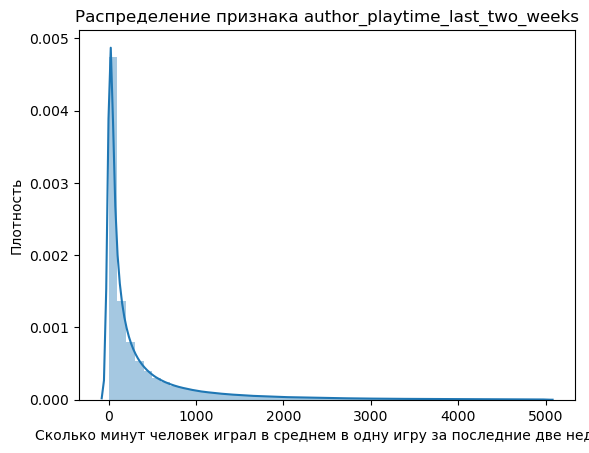

In [79]:
make_distplot('author_playtime_last_two_weeks', 
              df_users[(df_users['author_playtime_last_two_weeks'] != 0) & (df_users['author_playtime_last_two_weeks'] < 5_000)], 
              'Сколько минут человек играл в среднем в одну игру за последние две недели', 
              rotation=False)

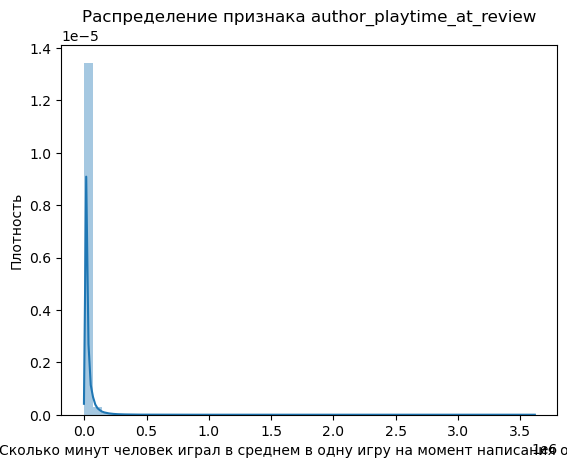

In [80]:
make_distplot('author_playtime_at_review', df_users, 
              'Сколько минут человек играл в среднем в одну игру на момент написания отзывов', 
              rotation=False)

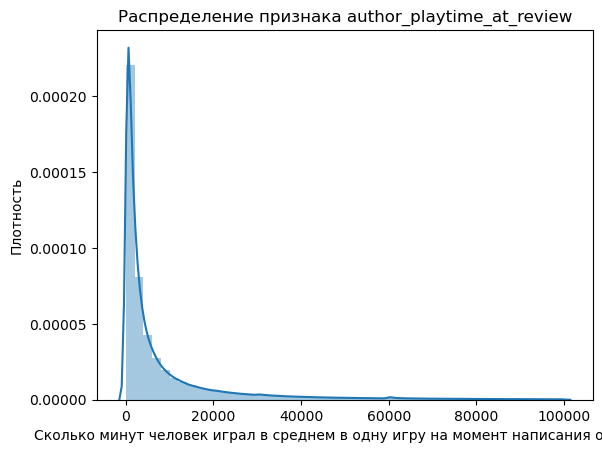

In [81]:
make_distplot('author_playtime_at_review', 
              df_users[(df_users['author_playtime_at_review'] != 0) & (df_users['author_playtime_at_review'] < 100_000)], 
              'Сколько минут человек играл в среднем в одну игру на момент написания отзывов', 
              rotation=False)

## Корреляционный анализ

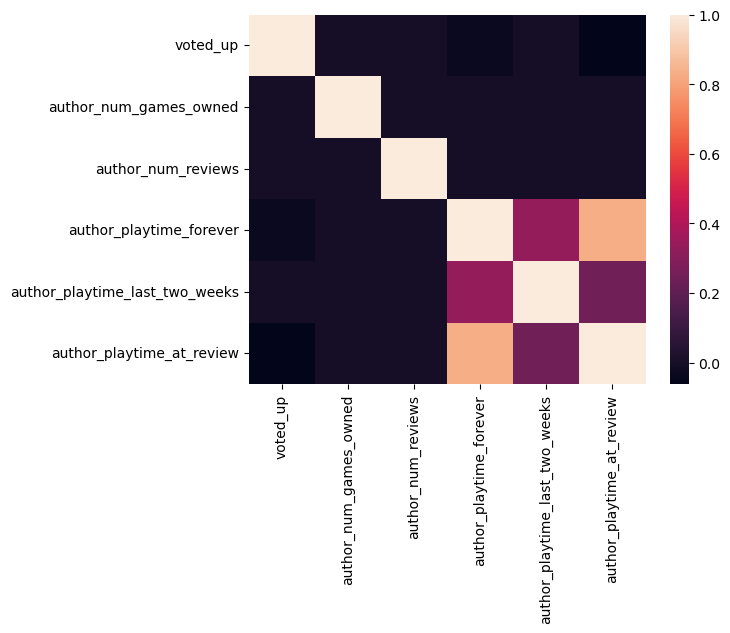

In [82]:
corr_matrix = df_users.corr()
sns.heatmap(corr_matrix)
plt.show()

**Видим, что скоррелированы все те же признаки playtime forever / last two weeks / at review**

# Итоги:
- При делении что по пользователям, что по играм, можем наблюдать одни и те же тренды для признаков
- Важно брать активных пользователей и популярные игры для дальнейшего построения рекомендательной системы, так как мы наблюдаем разные тренды для них и менее активных пользователей/ менее популярных игр.
- Важно также поработать с выбросами и скоррелированными признаками перед построением моделей